# Проект 5. Компьютер говорит "Нет"

#### Скоринговая модель предсказания дефолта клиентов банка

### Импорт библиотек

In [1]:
import numpy as np  # Библиотека linear algebra
import pandas as pd  # Библиотека Data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from pandas import Series

import matplotlib.pyplot as plt  # Визуализация для Python
import seaborn as sns  # Статистика и визуализация
from datetime import datetime  # Работа с датами и временем


# Библиотека Scikit-learn: Machine Learning для Python
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

import warnings  # Фильтрация предупреждений
warnings.filterwarnings("ignore")

In [3]:
# Фиксация RANDOM_SEED для воспроизводимости экспериментов
RANDOM_SEED = 42

In [4]:
# Фиксация версии пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

In [5]:
pd.set_option('display.max_columns', 30)  # Показывать больше столбцов

### Загрузка данных

In [6]:
# path = './'
path = '/kaggle/input/sf-dst-scoring/'

# Импорт и просмотр данных
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

### Первичный анализ данных

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Выделяется параметр Education наличием пропусков

In [8]:
train.education.isnull().value_counts()

False    73492
True       307
Name: education, dtype: int64

### Функции

In [9]:
# Визуализаця

def numerical_chart(data, col, size=6):  # Для числовых признаков
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle(
        'Гисторгамма и boxplot для {0} по default'.format(col), fontsize=20)
    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8)
    g2.boxplot([data[data.default == 0][col], data[data.default == 1][col]])
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.xticks([1, 2], ["0", "1"])
    plt.show


def conf_mat(y_valid, y_pred):   # Для Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')
    plt.show()

# Работа с выбросами


def outliers_iqr(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    return lower, upper, iqr


def outliers(data, col):
    l, r, iqr = outliers_iqr(data[col])

    out = (data[col] > r).sum() + (data[col] < l).sum()
    out_percent = round(
        out/data[col].count()*100, 1
    )

    print(f': {col}')
    print(f'IQR: {iqr}, границы выбросов: [{l}, {r}]')
    print(f'Всего {out} ({out_percent}%) выбросов')

# Таблица метрик


metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']


def metrics_map(summary, col, y_valid, y_pred, y_pred_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(
        y_valid, y_pred), f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary

# Построение кривой ROC_AUC


def roc_auc(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

Описания полей датасета

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


### Работа с пропусками

In [10]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

In [11]:
display(train.education.value_counts(normalize=True, dropna=False))
display(test.education.value_counts(normalize=True, dropna=False))

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
NaN    0.004160
ACD    0.002629
Name: education, dtype: float64

SCH    0.526507
GRD    0.313709
UGR    0.135685
PGR    0.016727
NaN    0.004704
ACD    0.002669
Name: education, dtype: float64

Пропуски обнаружены только в признаке education, заполним значением моды

In [12]:
train.education.fillna(
    train.education.mode()[0],
    inplace=True
)
test.education.fillna(
    test.education.mode()[0],
    inplace=True
)

### Feature engineering

Признак app_date

In [13]:
train.app_date.head(2), test.app_date.head(2)

(0    01FEB2014
 1    12MAR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 Name: app_date, dtype: object)

Преобразуем его в формат даты

In [14]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
train.app_date.head(2), test.app_date.head(2)

(0   2014-02-01
 1   2014-03-12
 Name: app_date, dtype: datetime64[ns],
 0   2014-03-22
 1   2014-01-24
 Name: app_date, dtype: datetime64[ns])

Создание нового признака - количество дней до сегодняшнего числа

In [15]:
today = pd.to_datetime('15MAR2021')
train['days'] = (today - train.app_date).dt.days
test['days'] = (today - test.app_date).dt.days

Разделение данных на бинарные, категориальные и числовые признаки

In [16]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']
num_cols = ['days', 'age', 'decline_app_cnt',
            'score_bki', 'bki_request_cnt', 'income']

Первичный анализ целевой переменной

In [17]:
train['default'].value_counts(normalize=True, dropna=False)

0    0.873006
1    0.126994
Name: default, dtype: float64

Обнаружен большой дисбаланс в сторону бездефолтных клиентов, измерим соотношение двух категорий

In [18]:
factor = int(
    train[train.default == 0].default.shape[0] /
    train[train.default == 1].default.shape[0]
)
print(factor)

6


Сбалансируем между собой обе категории путем кратного увеличения дефолтных клиентов с помощью копирования (oversamping)

In [19]:
train_1 = train[train.default == 1]
for _ in range(factor):
    train = train.append(train_1).reset_index(drop=True)

In [20]:
train['default'].value_counts(normalize=True, dropna=False)

1    0.504526
0    0.495474
Name: default, dtype: float64

Выбросы в числовых признаках

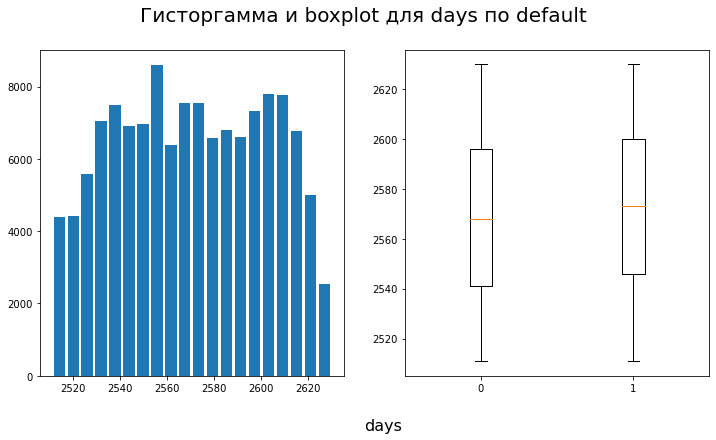

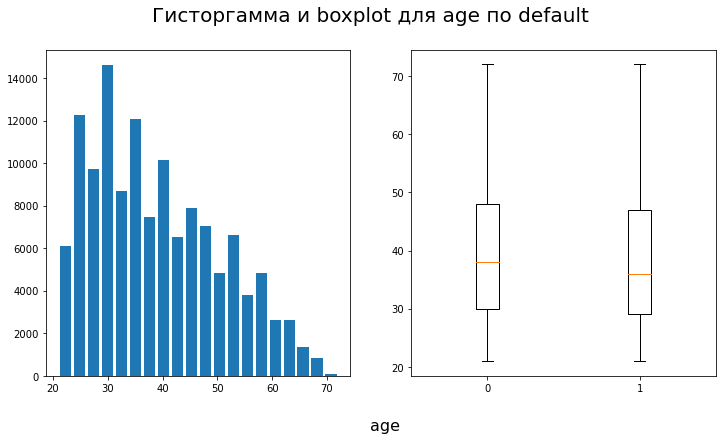

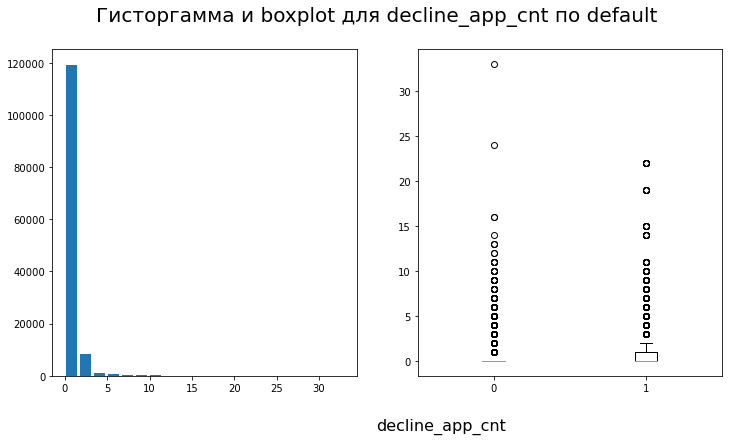

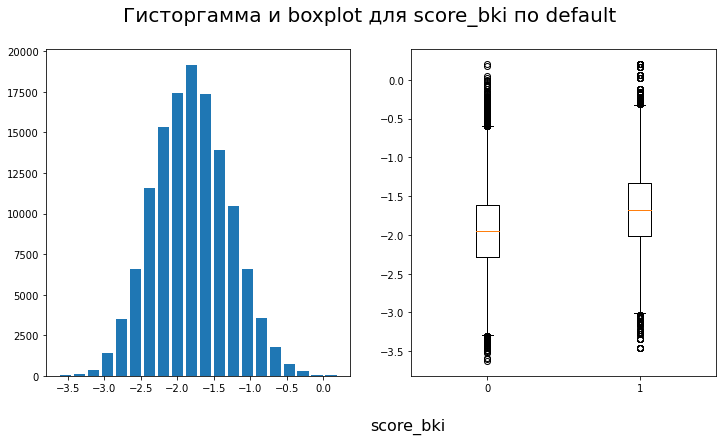

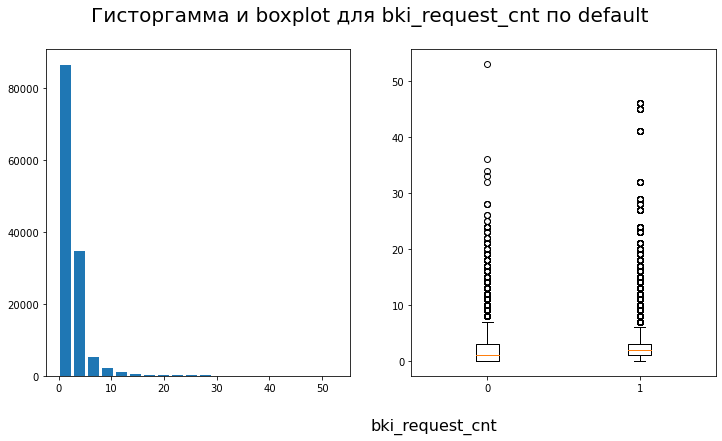

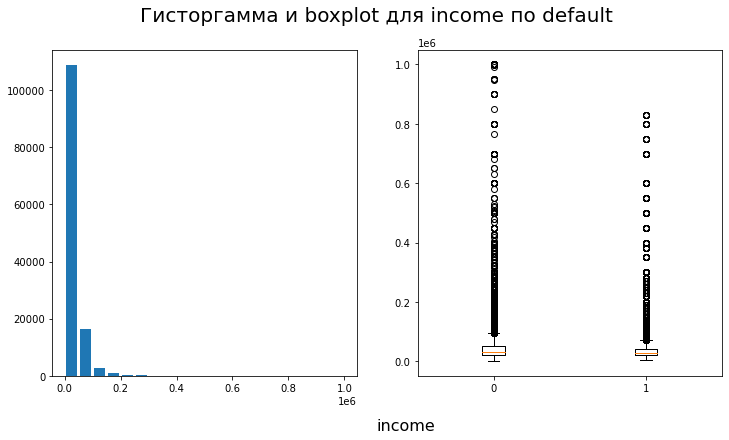

In [21]:
for col in num_cols:
    numerical_chart(train, col)

In [22]:
for col in num_cols:
    outliers(train, col)

: days
IQR: 54.0, границы выбросов: [2463.0, 2679.0]
Всего 0 (0.0%) выбросов
: age
IQR: 18.0, границы выбросов: [2.0, 74.0]
Всего 0 (0.0%) выбросов
: decline_app_cnt
IQR: 0.0, границы выбросов: [0.0, 0.0]
Всего 28587 (22.0%) выбросов
: score_bki
IQR: 0.7081654850000001, границы выбросов: [-3.2317855925, -0.3991236524999999]
Всего 555 (0.4%) выбросов
: bki_request_cnt
IQR: 2.0, границы выбросов: [-2.0, 6.0]
Всего 5715 (4.4%) выбросов
: income
IQR: 25000.0, границы выбросов: [-17500.0, 82500.0]
Всего 8361 (6.4%) выбросов


Удаление выбросов

In [23]:
num_cols_outliers = ['bki_request_cnt', 'score_bki', 'income']
for col in num_cols_outliers:
    d = outliers_iqr(train[col])
    train = train.loc[train[col].between(d[0], d[1])]

Удаление смещения в распределении переменных с помощью логарифмирования

In [24]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in num_cols_log:
    train[col] = np.log(train[col] + 1)

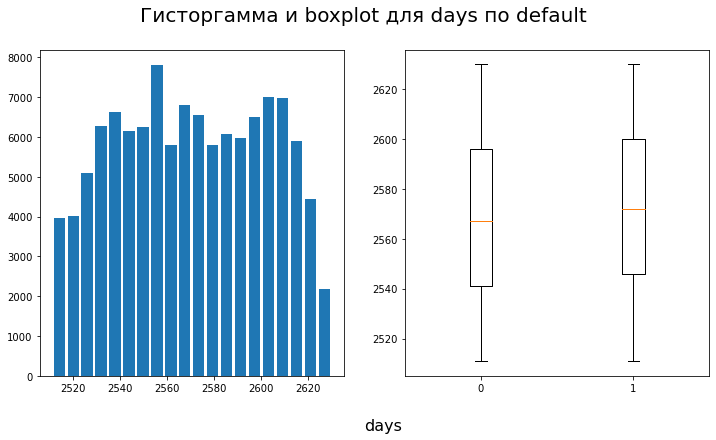

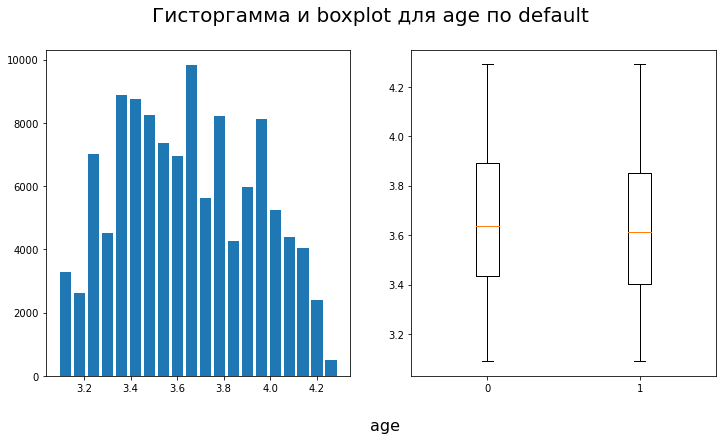

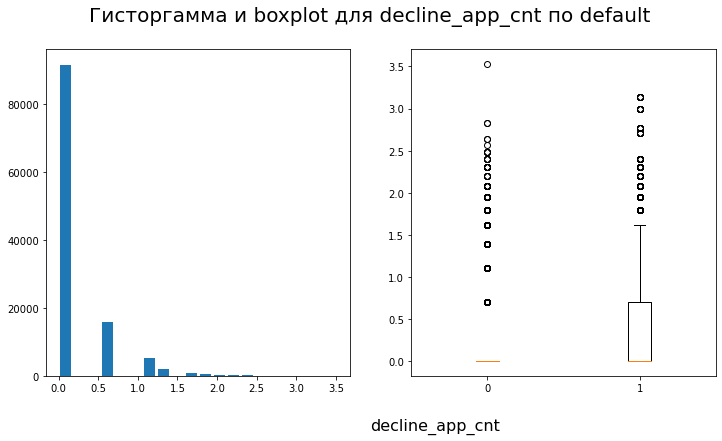

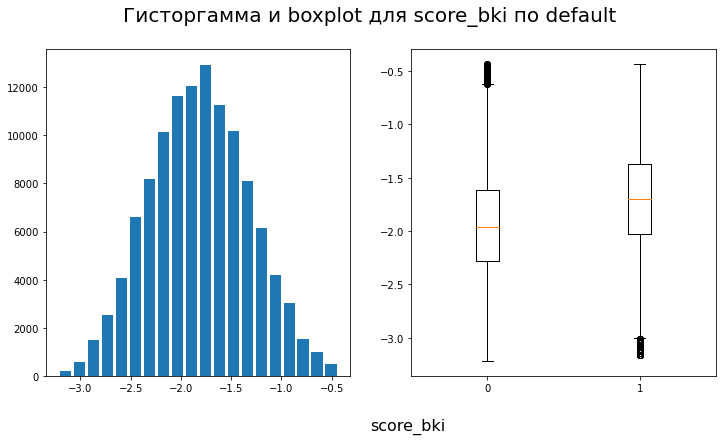

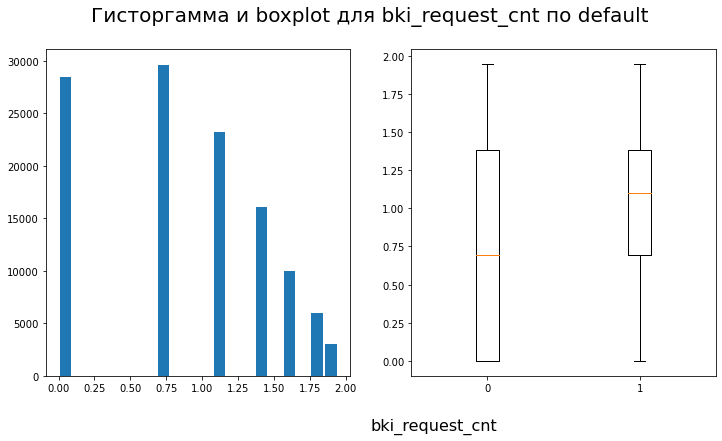

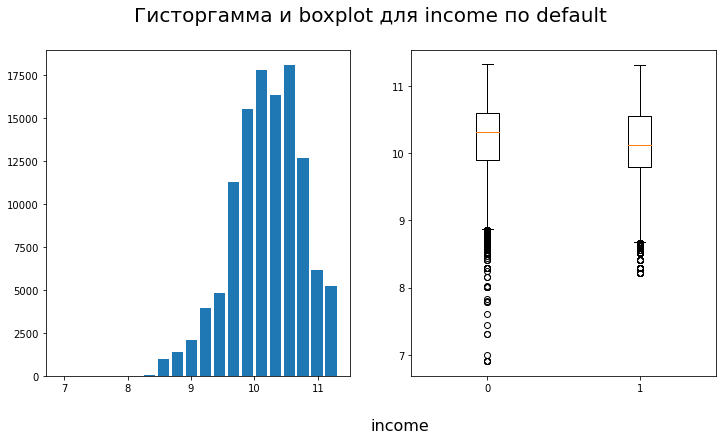

In [25]:
for col in num_cols:
    numerical_chart(train, col)

Распределение выровнено, повторим то же и для признаков из test

In [26]:
for col in num_cols_log:
    test[col] = np.log(test[col] + 1)

In [27]:
corr = train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income
days,1.000,-0.021,0.020,0.058,-0.008,-0.007
age,-0.021,1.000,-0.153,-0.110,0.046,-0.159
decline_app_cnt,0.020,-0.153,1.000,0.213,0.077,0.007
score_bki,0.058,-0.110,0.213,1.000,0.105,0.001
bki_request_cnt,-0.008,0.046,0.077,0.105,1.000,0.054
income,-0.007,-0.159,0.007,0.001,0.054,1.000


Признаки не показывают значительной корреляции

Преобразование бинарных признаков с помощью LabelEncoder

In [28]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,2599
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,2560
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,2599
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,2608
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,2523


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,2550
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,2607
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,2549
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,2597
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,2596


Преобразование категориальных признаков с помощью метода .get_dummies

In [29]:
train = pd.get_dummies(train, columns=cat_cols)
test = pd.get_dummies(test, columns=cat_cols)

In [30]:
cat_cols_dummies = [c1 for c in cat_cols for c1 in train.columns if c1.startswith(
    c)]  # Новый список категориальных признаков

Значимость числовых признаков

Text(0.5, 0, 'F-value')

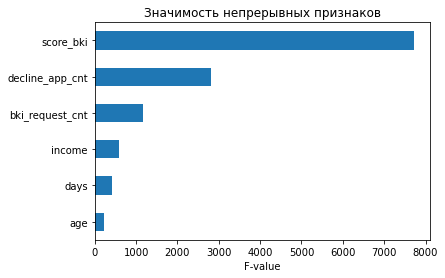

In [31]:
imp_num = Series(f_classif(train[num_cols], train.default)[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных признаков')
plt.xlabel('F-value')

Значимость бинарных признаков

Text(0.5, 1.0, 'Значимость бинарных признаков')

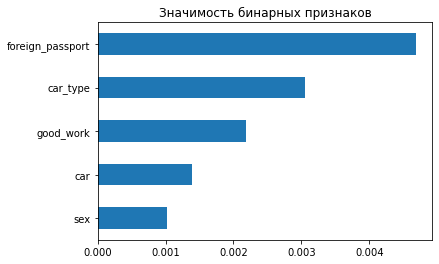

In [32]:
# Значимость бинарных признаков
imp_bin = Series(mutual_info_classif(train[bin_cols],
                                     train.default,
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

Text(0.5, 1.0, 'Значимость бинарных признаков')

Значимость категориальных признаков

Text(0.5, 1.0, 'Значимость категорисльных признаков')

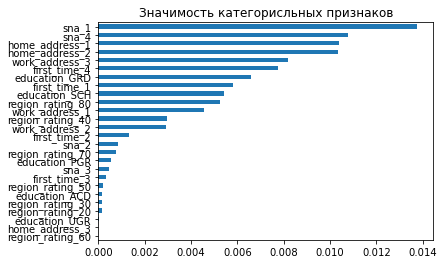

In [33]:
imp_cat = pd.Series(mutual_info_classif(train[cat_cols_dummies],
                                        train.default,
                                        discrete_features=True),
                    index=cat_cols_dummies)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категорисльных признаков')

Подготовка данных к обучению

Генерация полиномиальных признаков из числовых

In [34]:
polynom = PolynomialFeatures(2)

x_polynom_train = polynom.fit_transform(train[num_cols].values)
x_polynom_test = polynom.fit_transform(test[num_cols].values)

Стандартизация

In [35]:
X_num_train = StandardScaler().fit_transform(x_polynom_train)
X_num_test = StandardScaler().fit_transform(x_polynom_test)

In [36]:
X_num_train.shape, X_num_test.shape

((116262, 28), (36349, 28))

Объединение

In [37]:
X = np.hstack([X_num_train, train[bin_cols].values,
               train[cat_cols_dummies].values])
Y = train.default.values

X_ids_test = np.hstack(
    [X_num_test, test[bin_cols].values,  test[cat_cols_dummies].values])
ids_test = test.client_id

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    shuffle=True
)

Таблица с метриками

In [39]:
summary = pd.DataFrame(index=metrics)

Первый этап обучения

In [40]:
model = LogisticRegression(random_state= RANDOM_SEED, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [41]:
LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

LogisticRegression(max_iter=1000, random_state=42)

In [42]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model.predict(X_valid)

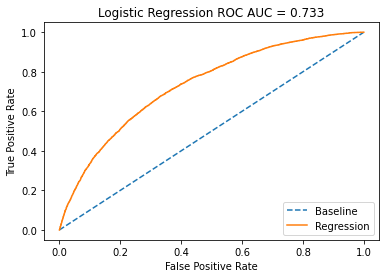

In [43]:
roc_auc(y_valid, y_pred_probs)

In [44]:
metrics_map(summary, 'model_1', y_valid, y_pred, y_pred_probs)

,model_1
accuracy,0.671053
precision,0.666333
recall,0.686770
f1_score,0.676397
ROC_AUC,0.732699


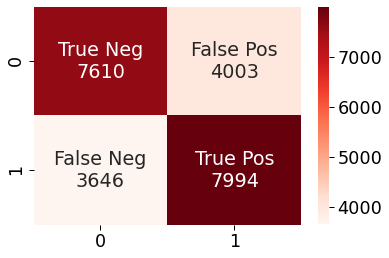

In [45]:
conf_mat(y_valid, y_pred)

Подбор гиперпараметров (регуляризация)

In [46]:
C = np.logspace(0, 4, 10)  # Ограничения для параметра регуляризации

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 166.81005372000593


Обучение после регуляризации

In [47]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=166.81005372000593, max_iter=1000)

In [48]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:, 1]

y_pred = model.predict(X_valid)

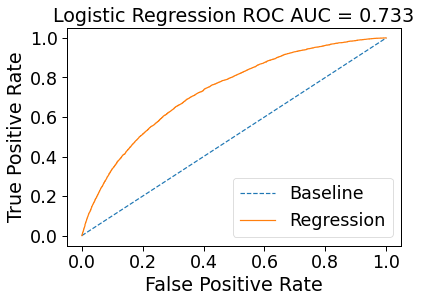

In [49]:
roc_auc(y_valid, y_pred_probs)

In [50]:
metrics_map(summary, 'model_2', y_valid, y_pred, y_pred_probs)

,model_1,model_2
accuracy,0.671053,0.671956
precision,0.666333,0.667362
recall,0.686770,0.687199
f1_score,0.676397,0.677135
ROC_AUC,0.732699,0.732832


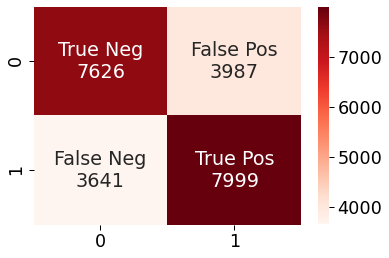

In [51]:
conf_mat(y_valid, y_pred)

Предсказание и сохранение submission

In [52]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X, Y)
probs = model.predict_proba(X_ids_test)
probs = probs[:, 1]

In [53]:
my_submission = pd.DataFrame({'client_id': ids_test,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.head(10)

,client_id,default
0,74835,0.245984
1,17527,0.725604
2,75683,0.369427
3,26883,0.402910
4,28862,0.171126
5,99881,0.600903
6,26630,0.776490
7,79934,0.228034
8,16605,0.102355
9,105449,0.148118
